# Header

In [71]:
import glob
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
import his_preprocess

In [ ]:

scale_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

file_dic ={}
for target_var in ["2m_temperature"]:

    if target_var == '2m_temperature':
        # file_dic[0] = sorted(glob.glob('/data/GC_output/percent2/GC_11111111111_250_*.nc'))
        for i, scale in enumerate(scale_list):
            file_dic[i] = sorted(glob.glob(f'/geodata2/S2S/DL/GC_input/shuffle/ERA5_{scale}_*_0.nc'))
            #print(file_dic[i])

    # Assign base colors for each partition
    colors_list = [
        '#008000', # 초록
        '#FF00FF', # 마젠타
        '#0000FF', # 파랑
        '#800080', # 보라
        '#FF69B4', # 핫핑크
        '#FFD700', # 골드
        '#FF0000', # 빨강
        '#00FF00', # 라임
        '#00FFFF', # 시안
        '#FFA500', # 주황
        '#800000', # 마룬
        '#4B0082', # 인디고
        '#8B4513', # 새들브라운
        '#FF4500', # 오렌지레드
        '#00FF7F', # 스프링그린
        '#1E90FF', # 도저블루
        '#FF1493', # 딥핑크
        '#7B68EE', # 미디엄슬레이트블루
        '#20B2AA', # 라이트시그린
        '#DAA520' # 골든로드
    ]

    def extract_perturbation_info(filename):
        match = filename.split("/")[-1].split("_")
        if match:
            scale = match[1]  # perturbation 코드
            percent = match[2]  # 값 (예: 0.001)
            ens = match[3]  # 지역 코드 (예: 9p)
            #print(f"{scale}_{percent}_{ens}")
            return f"{scale}_{percent}_{ens}"
        else:
            return None

    # Collect perturbation files with labels and colors
    perturb_files = []
    
    for i, partition_files in file_dic.items():
        base_color = colors_list[i % len(colors_list)]
        num_files = len(partition_files)
        # Generate different shades of the base color
        colors = sns.light_palette(base_color, n_colors=num_files + 2)[1:-1]
        for i, file in enumerate(partition_files):
            perturb_info = extract_perturbation_info(file)
            if perturb_info:
                label = f"{perturb_info}"
                color = colors[i % len(colors_list)]
                perturb_files.append((label, color, file))

    # perturb_datasets_raw = []
    perturb_datasets_mean = []

    def process_file(file_info):
        label, color, file = file_info
        print(f"processing {file}")
        # return {"mean": (label, color, his_preprocess.weighted_mean(dataset_raw)), "raw": (label, color, dataset_raw)}
        return {"mean": (label, color, his_preprocess.weighted_mean(xr.open_dataset(file, engine="netcdf4")[target_var]))}

    with Pool() as executor:
        results = executor.map(process_file, perturb_files)

    perturb_datasets_mean = [result["mean"] for result in results]
    # perturb_datasets_raw = [result["raw"] for result in results]

    if target_var == '2m_temperature':
        with open('/data/GC_output/analysis/shuffle/ERA5_t2m_GlobAvg.pkl', 'wb') as f:
            pickle.dump(perturb_datasets_mean, f)
        # with open('/data/GC_output/analysis/shuffle/sparse_GC_t2m_Globraw.pkl', 'wb') as f:
        #     pickle.dump(perturb_datasets_raw, f)

In [16]:
dataset_1 = xr.open_dataset("/home/hiskim1/graphcast/shuffle/weighted_mid_input.nc").squeeze().isel(time=0) 
dataset_2 = xr.open_dataset('/geodata2/S2S/DL/GC_input/2021-06-21/ERA5_input.nc').squeeze().isel(time=0) 

data_1 = his_preprocess.jax_weighted_mean(dataset_1)
data_2 = his_preprocess.jax_weighted_mean(dataset_2)


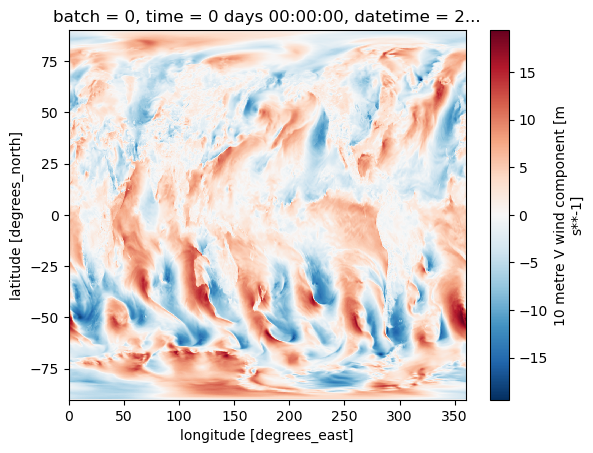

In [39]:

# plt.figure(figsize=(15, 5))
# plt.plot(data_1.time, data_1.isel(level=36)["geopotential"], label="perturbed")
# plt.plot(data_1.time, data_2.isel(level=36)["geopotential"], label="control")
# plt.legend()

dataset_2[ '10m_v_component_of_wind'].plot()

# Why perturbations impose cooler predictions?

**hypothesis**
1) latitude map되면서 달라졋을 가능성 -> No
2) negative value 처리를 안 해줘서 그런가 -> No
3) 다른 변수들은? -> 다름.

=> 

### Test Input 생성

In [17]:
import his_utils

region_low = {"lat": (-30, 30), "lon": (0, 360)}
region_mid_boreal = {"lat": (30, 60), "lon": (0, 360)}
region_mid_austral = {"lat": (-60, -30), "lon": (0, 360)}
region_high_boreal = {"lat": (60, 90), "lon": (0, 360)}
region_high_austral = {"lat": (-90, -60), "lon": (0, 360)}

dataset = xr.open_dataset('/geodata2/S2S/DL/GC_input/2021-06-21/ERA5_input.nc')


In [3]:
empty = his_utils.add_region_perturbation(
    dataset,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.5,
    perturb_timestep = [0, 1],
    num_points = round(103680 * 10),
    wipe_out = True
)


In [7]:
# empty.isel(time=1, level=30)['geopotential'].plot()
empty.to_netcdf('empty_input.nc')

In [18]:

# Low Latitude
low_lat = his_utils.add_regional_shuffle_perturbation(
    dataset,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.3,
    perturb_timestep = [0, 1],
    num_points = round(23568048 * (5 / 10)),
    wipe_out = False,
    region = region_low,
)

low_lat.to_netcdf(f'cliped_low_input.nc')

# Mid Latitude
tmp = his_utils.add_regional_shuffle_perturbation(
    dataset,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.3,
    perturb_timestep = [0, 1],
    num_points = round(23568048 * (5 / 10) / 2),
    wipe_out = False,
    region = region_mid_austral,
)

mid_lat = his_utils.add_regional_shuffle_perturbation(
    tmp,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.3,
    perturb_timestep = [0, 1],
    num_points = round(23568048 * (5 / 10) / 2),
    wipe_out = False,
    region = region_mid_boreal,
)

mid_lat.to_netcdf(f'cliped_mid_input.nc')


# High Latitude
tmp2 = his_utils.add_regional_shuffle_perturbation(
    dataset,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.3,
    perturb_timestep = [0, 1],
    num_points = round(23568048 * (5 / 10) / 2),
    wipe_out = False,
    region = region_high_austral,
)

high_lat = his_utils.add_regional_shuffle_perturbation(
    tmp2,
    variables = his_utils.PRESSURE_VARIABLE + his_utils.SURFACE_VARIABLE, 
    scale = 0.3,
    perturb_timestep = [0, 1],
    num_points = round(23568048 * (5 / 10) / 2),
    wipe_out = False,
    region = region_high_boreal,
)

high_lat.to_netcdf(f'cliped_high_input.nc')



### Test Input 처리

In [9]:
raw = {
"low latitude": xr.open_dataset("cliped_low_output.nc").squeeze(),    
"mid latitude": xr.open_dataset("cliped_mid_output.nc").squeeze(),
"high latitude": xr.open_dataset("cliped_high_output.nc").squeeze(),
"control": xr.open_dataset("/data/GC_output/2021-06-21/GC_output_10.nc").squeeze()
}

regional = {
"low latitude": his_preprocess.weighted_mean(raw["low latitude"].resample(time="1D").mean()),    
"mid latitude": his_preprocess.weighted_mean(raw["mid latitude"].resample(time="1D").mean()),
"high latitude": his_preprocess.weighted_mean(raw["high latitude"].resample(time="1D").mean()),
"control": his_preprocess.weighted_mean(raw["control"].resample(time="1D").mean())
}

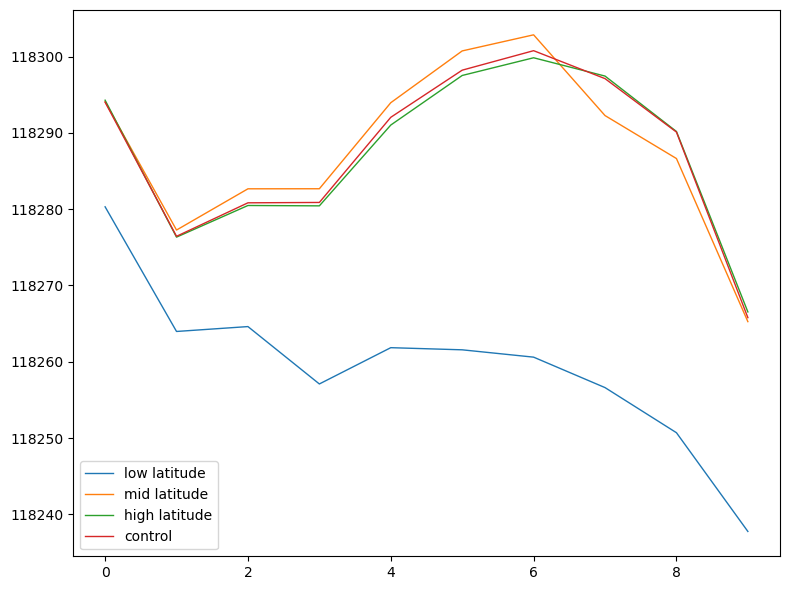

In [11]:

plt.figure(figsize=(8, 6))

for region, data in regional.items():
    plt.plot(data.sel(level=200)["geopotential"], label=region, linewidth=1)
    plt.legend()

plt.tight_layout()
plt.show()
# plt.savefig("output_daily.png")

# 낙서장


In [86]:
data=xr.open_dataset("/data/GC_output/proportional/GC_0.01_15_0.nc").squeeze()#.isel(time=0).sel(lat=slice(35,42), lon=slice(124,130))["2m_temperature"]
data2=xr.open_dataset("/geodata2/S2S/DL/GC_input/proportional/ERA5_0.005_90_0.nc").squeeze()

origin = xr.open_dataset('/data/GC_output/2021-06-21/GC_output_10.nc').squeeze()#.isel(time=0).sel(lat=slice(35,42), lon=slice(124,130))["2m_temperature"]

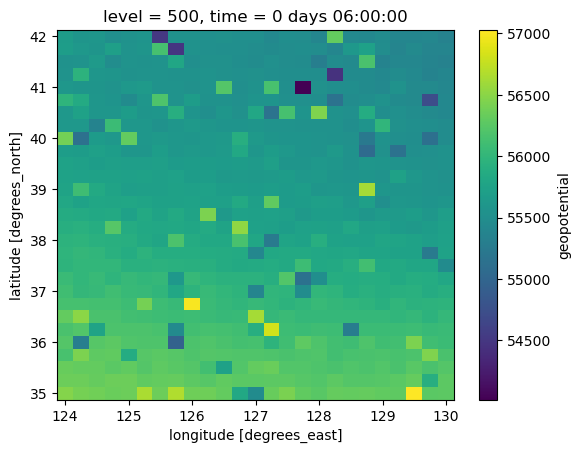

In [90]:
(data.isel(time=0).sel(lat=slice(35,42), lon=slice(124,130), level=500)["geopotential"]).plot()

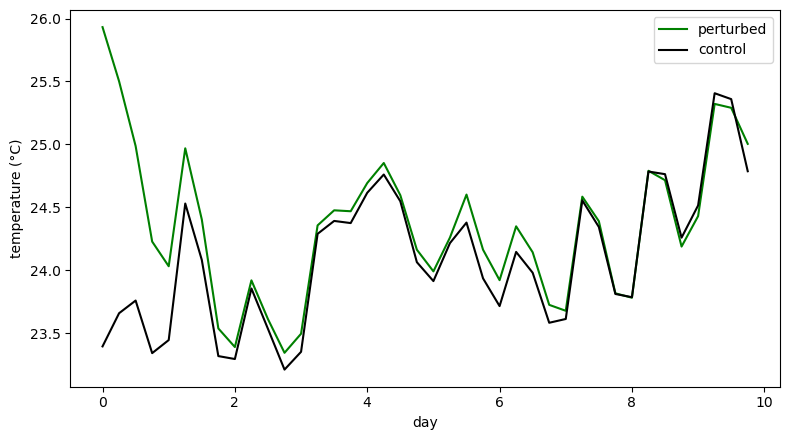

In [83]:
date = np.arange(0, 10, 0.25)
scale = 0.5
 # 37.25 125.5 / 39 125.75 
lat=32.5
lon=127.25
plt.figure(figsize=(16*scale, 9*scale))
plt.plot(date, data.sel(lat=lat, lon=lon)["2m_temperature"]-273.15, label="perturbed", color="green")
plt.plot(date, origin.sel(lat=lat, lon=lon)["2m_temperature"]-273.15, label="control", color="black")
plt.xlabel("day")
plt.ylabel("temperature (°C)")
plt.legend()
plt.tight_layout()